In [5]:
import os
from datetime import datetime
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

import pyarrow as pa
import pyarrow.parquet as pq

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

day_of_week: 0 = Sunday
1 = Monday
2 = Tuesday
3 = Wednesday
4 = Thursday
5 = Friday
6 = Saturday

In [2]:
cwd = os.getcwd()
print("Current Working Directory:", cwd)

Current Working Directory: c:\Users\35385\Desktop\CS_Summer_2024\Shared_GH\New-York-App\data-analytics\analysis


In [17]:
combined_df_dir = os.path.join(os.getcwd(), "..", "Datasets", "taxi_other")

# Define the directory where the data is located relative to the current working directory
print("Taxi Zone CSV Directory:", combined_df_dir)

# Define the file path relative to the data directory
combined_df_path = os.path.join(cwd, combined_df_dir, "combined_df.csv")

df = pd.read_csv(combined_df_path, keep_default_na=True, delimiter=",", skipinitialspace=True, encoding="Windows-1252")

Taxi Zone CSV Directory: c:\Users\35385\Desktop\CS_Summer_2024\Shared_GH\New-York-App\data-analytics\analysis\..\Datasets\taxi_other


In [18]:
df

,datetime_formatted,hour,day_of_week,week,month,day_of_month,year_month,zone,passenger_count
0,2021-01-01 00:00:00,0,4,53,0,1,2021-01,4,4
1,2021-01-01 00:00:00,0,4,53,0,1,2021-01,13,3
2,2021-01-01 00:00:00,0,4,53,0,1,2021-01,17,1
3,2021-01-01 00:00:00,0,4,53,0,1,2021-01,24,3
4,2021-01-01 00:00:00,0,4,53,0,1,2021-01,33,2
...,...,...,...,...,...,...,...,...,...
3343047,2024-04-01 00:00:00,0,0,14,3,1,2024-04,261,11
3343048,2024-04-01 00:00:00,0,0,14,3,1,2024-04,262,35
3343049,2024-04-01 00:00:00,0,0,14,3,1,2024-04,263,56
3343050,2024-04-01 00:00:00,0,0,14,3,1,2024-04,264,8


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3343052 entries, 0 to 3343051
Data columns (total 9 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   datetime_formatted  object
 1   hour                int64 
 2   day_of_week         int64 
 3   week                int64 
 4   month               int64 
 5   day_of_month        int64 
 6   year_month          object
 7   zone                int64 
 8   passenger_count     int64 
dtypes: int64(7), object(2)
memory usage: 229.5+ MB


In [20]:
df['datetime_formatted'] = pd.to_datetime(df['datetime_formatted'])

In [35]:
passenger_count = df["passenger_count"]

stats = passenger_count.describe()

missing_percentage = (passenger_count.isnull().mean() * 100).round(2)

cardinality = passenger_count.nunique()

total_value = passenger_count.sum()

# Prepare the report DataFrame
report = pd.DataFrame(columns=["Count", "Mean", "Std", "Min", "25%", "50%", "75%", "Max", "Missing%", "Cardinality", "Total"])

# Populate the report DataFrame
report.loc["passenger_count"] = [
    stats["count"], 
    stats["mean"], 
    stats["std"], 
    stats["min"], 
    stats["25%"], 
    stats["50%"], 
    stats["75%"], 
    stats["max"], 
    f"{missing_percentage}%", 
    cardinality,
    total_value
]

report.T

,passenger_count
Count,3343052.0
Mean,84.691553
Std,152.243795
Min,1.0
25%,2.0
50%,11.0
75%,97.0
Max,1734.0
Missing%,0.0%
Cardinality,1424


count: number of entries in each (hour) group.
mean: average number of passengers per ride in each group.
cardinality:  number of unique passenger counts in each group.
total_passenger_count: total number of passengers for all rides in each group.

In [38]:
def compute_stats(df, groupby_column):
    grouped = df.groupby(groupby_column)["passenger_count"].describe()
    grouped["cardinality"] = df.groupby(groupby_column)["passenger_count"].apply(lambda x: x.nunique())
    grouped["total_passenger_count"] = df.groupby(groupby_column)["passenger_count"].sum()
    return grouped.sort_values(by="total_passenger_count", ascending=False)

# List of columns to group by
groupby_columns = ["hour", "day_of_week", "week", "month", "day_of_month", "year_month", "zone"]

# Dictionary to store the results
stats_by_category = {}

# Compute stats for each category
for column in groupby_columns:
    stats_by_category[column] = compute_stats(df, column)

# Display the results for each category
for column, stats in stats_by_category.items():
    print(f"Stats for passenger_count by {column}:")
    print(stats)
    print("\n")

Stats for passenger_count by hour:
         count        mean         std  min  25%   50%    75%     max  \
hour                                                                    
18    152157.0  134.223591  210.363702  1.0  2.0  15.0  204.0  1531.0   
19    157379.0  128.134872  204.061635  1.0  2.0  14.0  190.0  1584.0   
17    148468.0  126.303089  195.429893  1.0  2.0  16.0  194.0  1431.0   
16    149106.0  123.171791  192.728579  1.0  2.0  15.0  189.0  1486.0   
15    145795.0  125.192599  194.966339  1.0  2.0  17.0  192.0  1551.0   
20    159126.0  108.547390  171.419768  1.0  2.0  13.0  159.0  1217.0   
14    144064.0  117.990588  181.776664  1.0  2.0  18.0  181.0  1358.0   
13    143126.0  113.403812  174.370635  1.0  2.0  18.0  175.0  1331.0   
21    159800.0   97.978611  155.852242  1.0  2.0  13.0  138.0  1181.0   
12    139823.0  110.413909  169.740446  1.0  2.0  18.0  168.0  1247.0   
22    161351.0   93.505631  152.784322  1.0  2.0  13.0  124.0  1179.0   
11    135845.0  

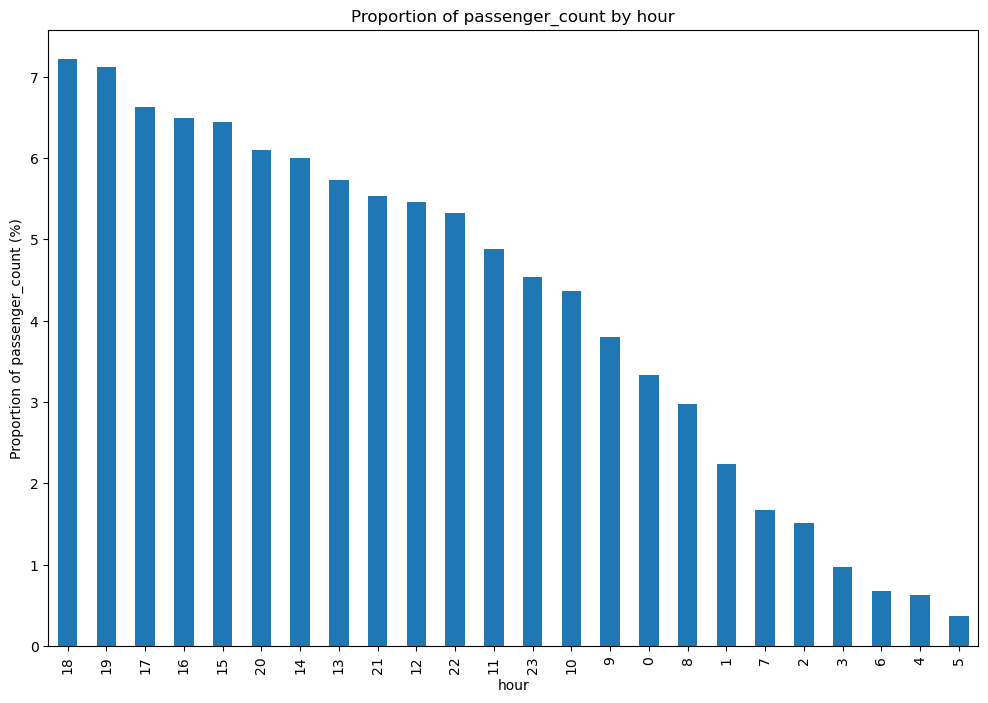

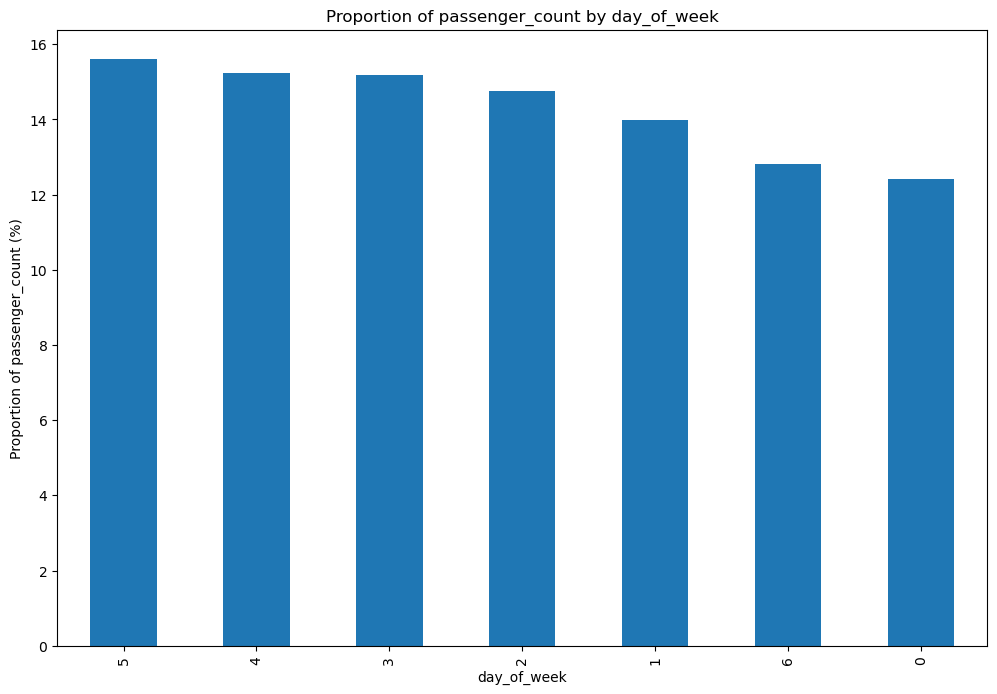

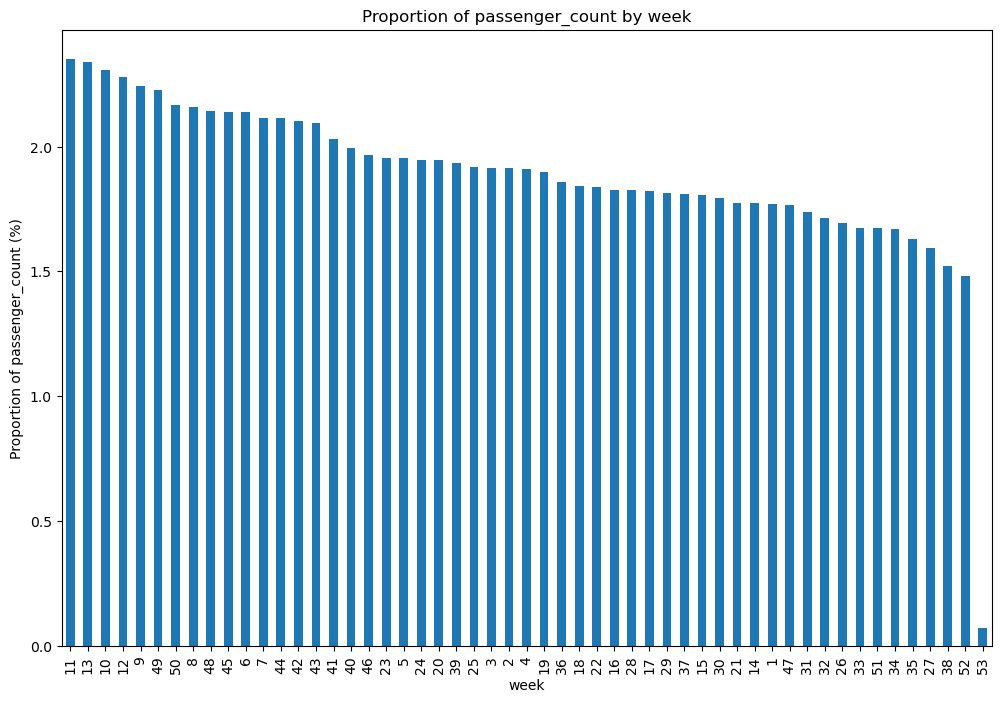

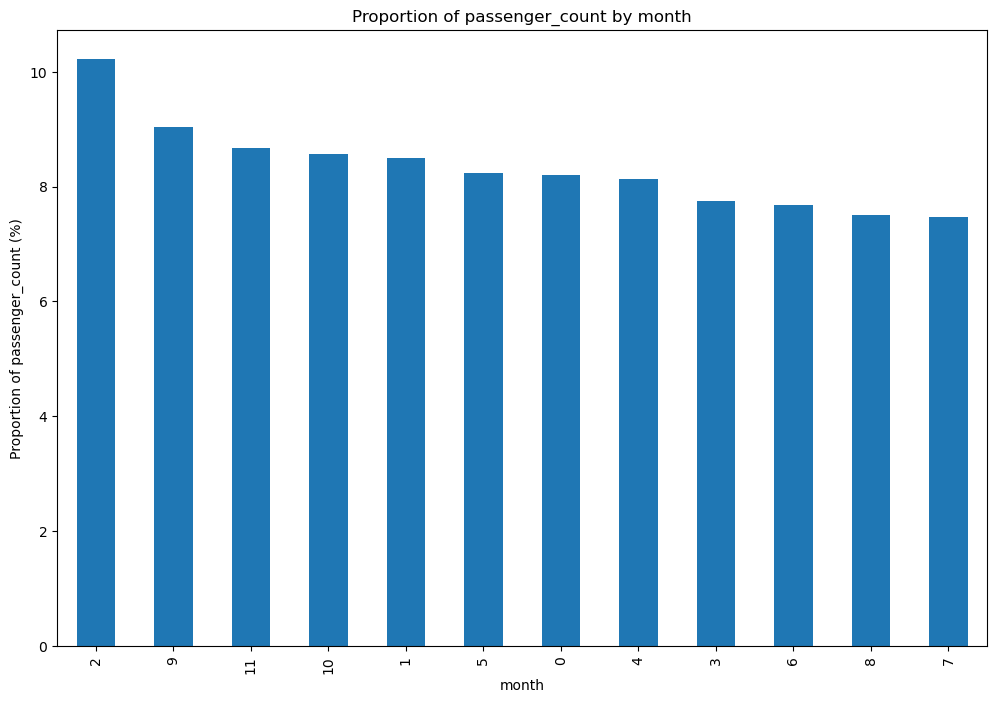

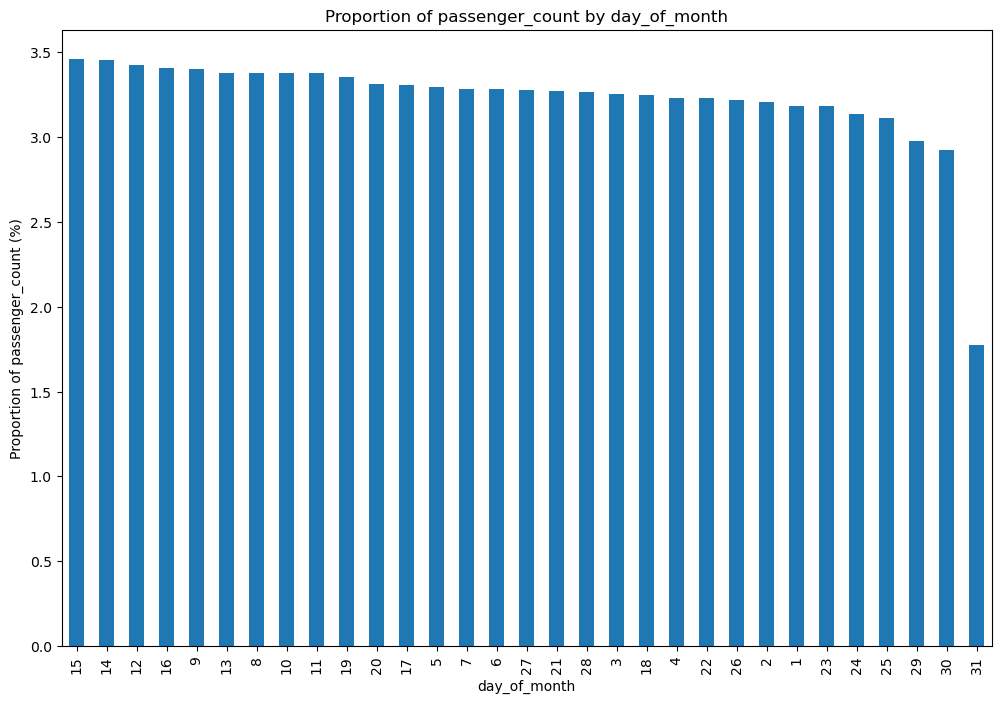

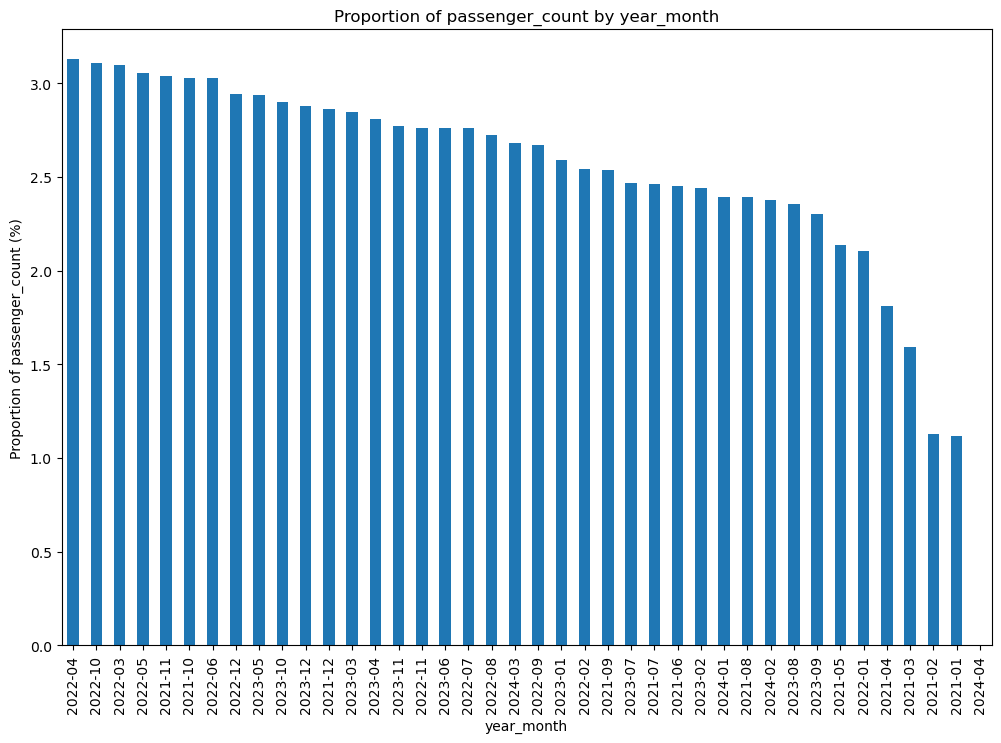

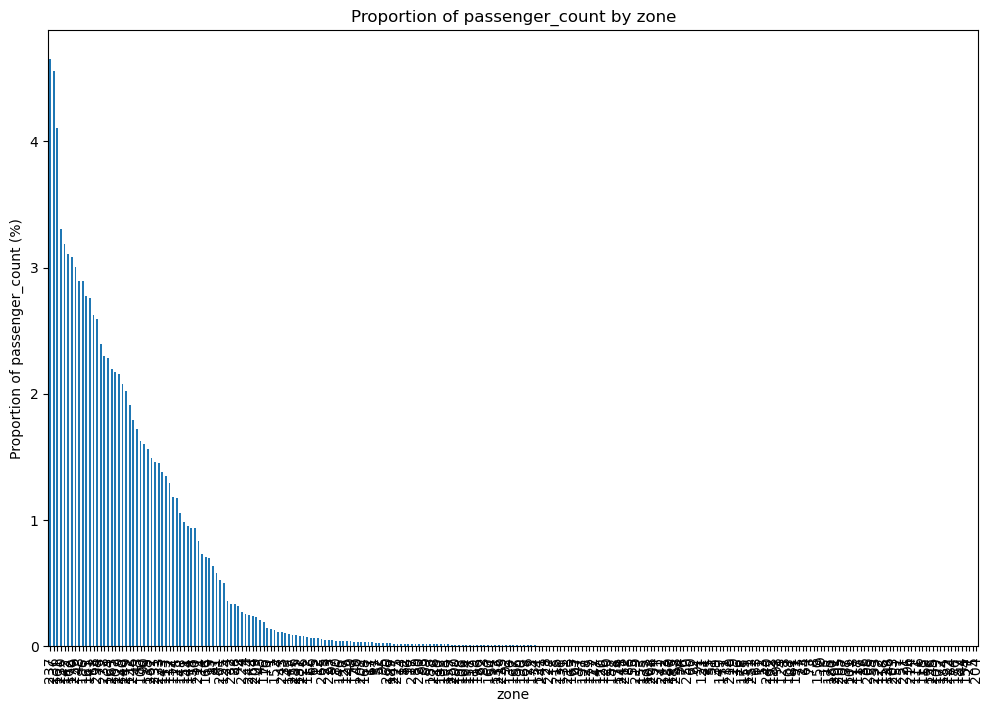

In [40]:
# Function to plot the proportion of passenger_count by a given feature
def plot_proportion_of_passenger_count(df, feature):
    # Calculate the total passenger_count for each value in the feature
    passenger_counts = df.groupby(feature)["passenger_count"].sum()

    # Filter features where the total passenger_count is greater than 200 (for better graphing)
    valid_features = passenger_counts[passenger_counts > 200].index.tolist()
    filtered_df = df[df[feature].isin(valid_features)]

    # Calculate the proportion of passenger_count for each value in the feature
    proportion_passenger_counts = (filtered_df.groupby(feature)["passenger_count"].sum() / filtered_df["passenger_count"].sum()) * 100

    # Sort based on the highest proportion
    sorted_proportions = proportion_passenger_counts.sort_values(ascending=False)

    # Plot the proportions
    sorted_proportions.plot(kind="bar", figsize=(12, 8))
    plt.title(f"Proportion of passenger_count by {feature}")
    plt.ylabel("Proportion of passenger_count (%)")
    plt.xlabel(feature)
    plt.show()

# List of columns to group by
groupby_columns = ["hour", "day_of_week", "week", "month", "day_of_month", "year_month", "zone"]

# Compute and plot proportions for each category
for column in groupby_columns:
    plot_proportion_of_passenger_count(df, column)

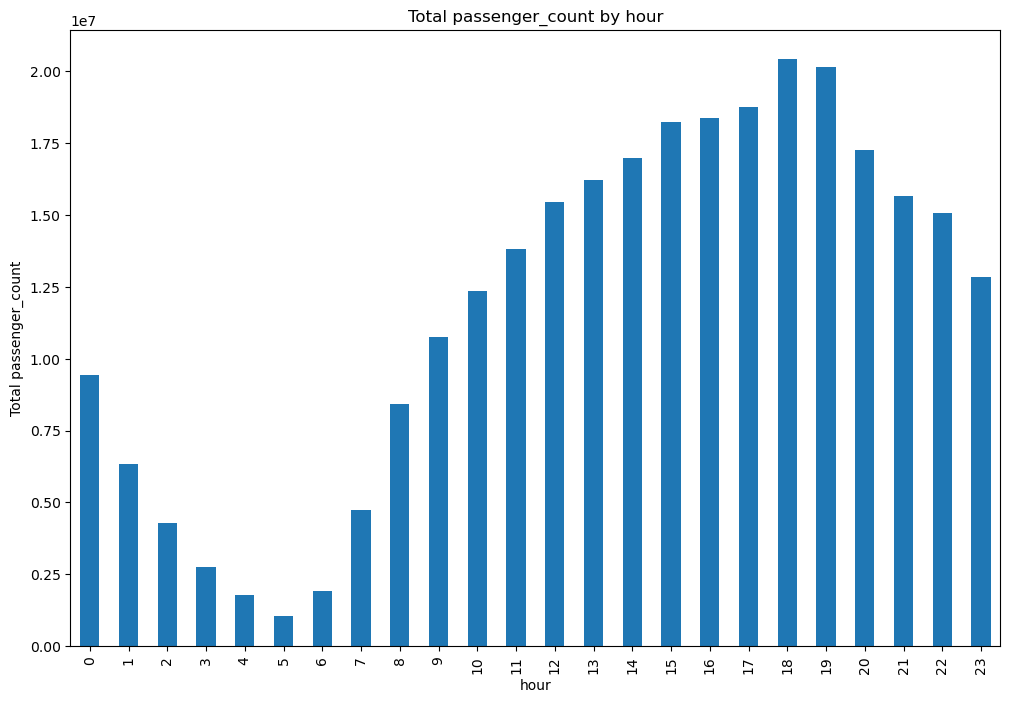

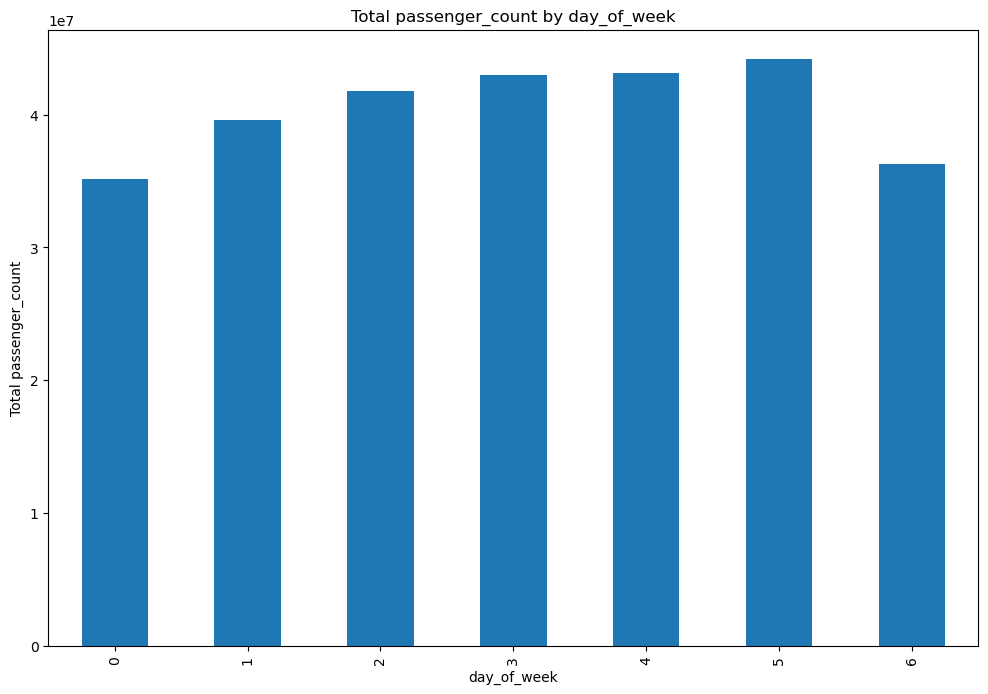

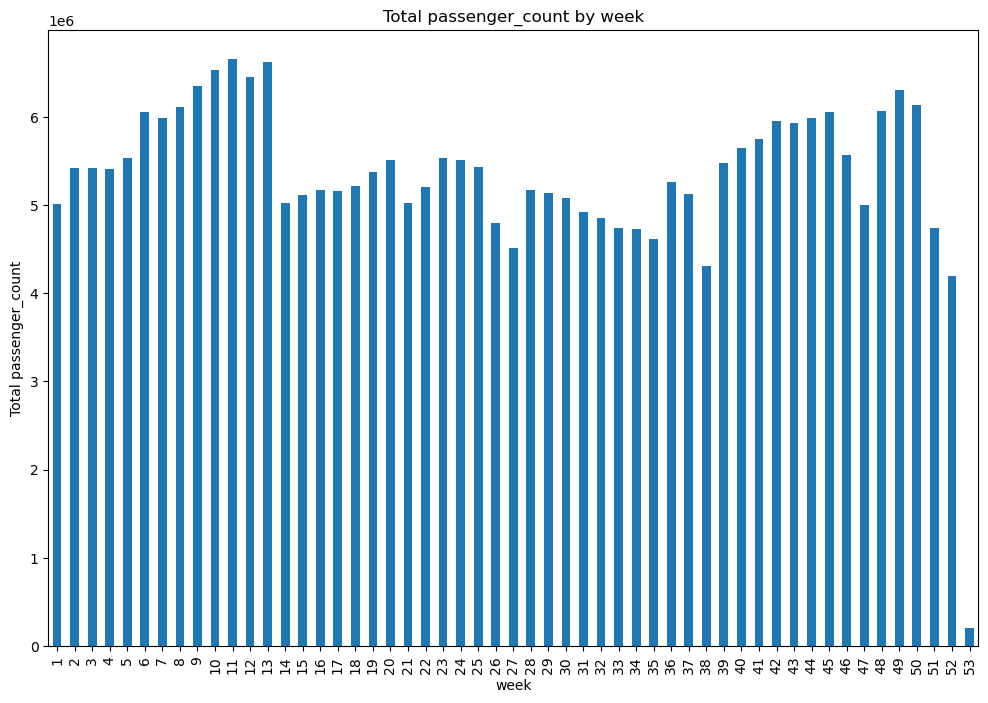

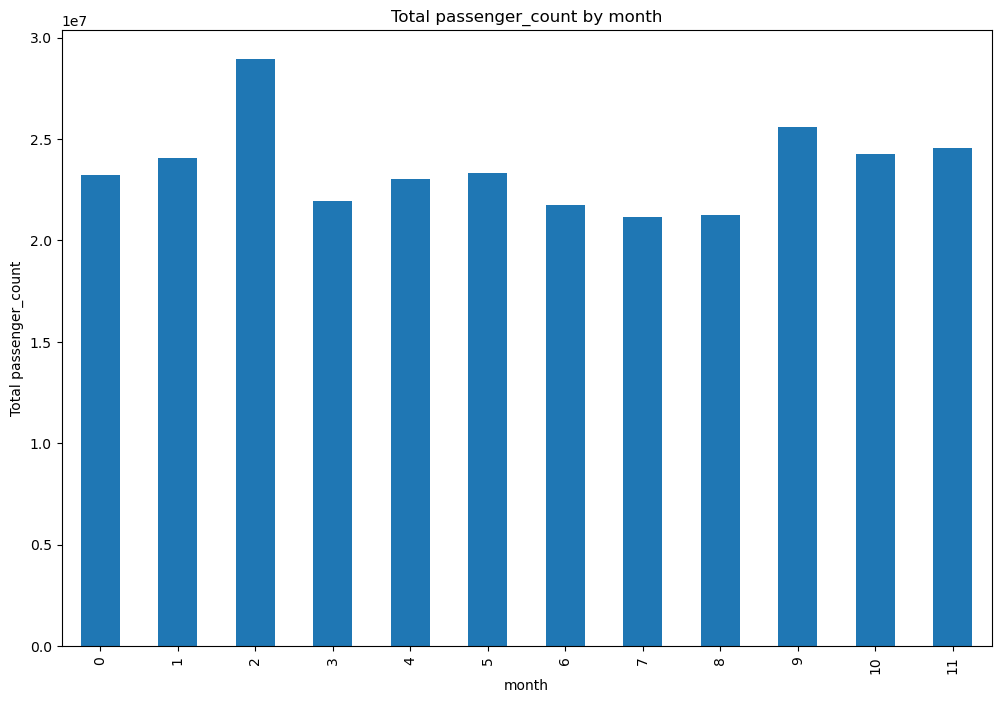

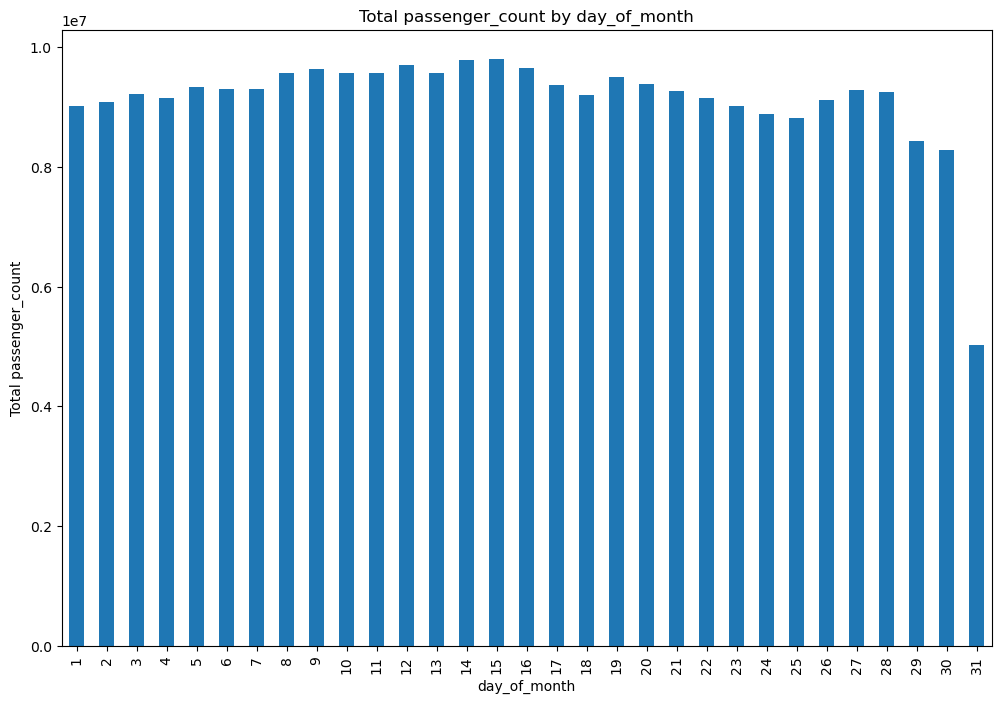

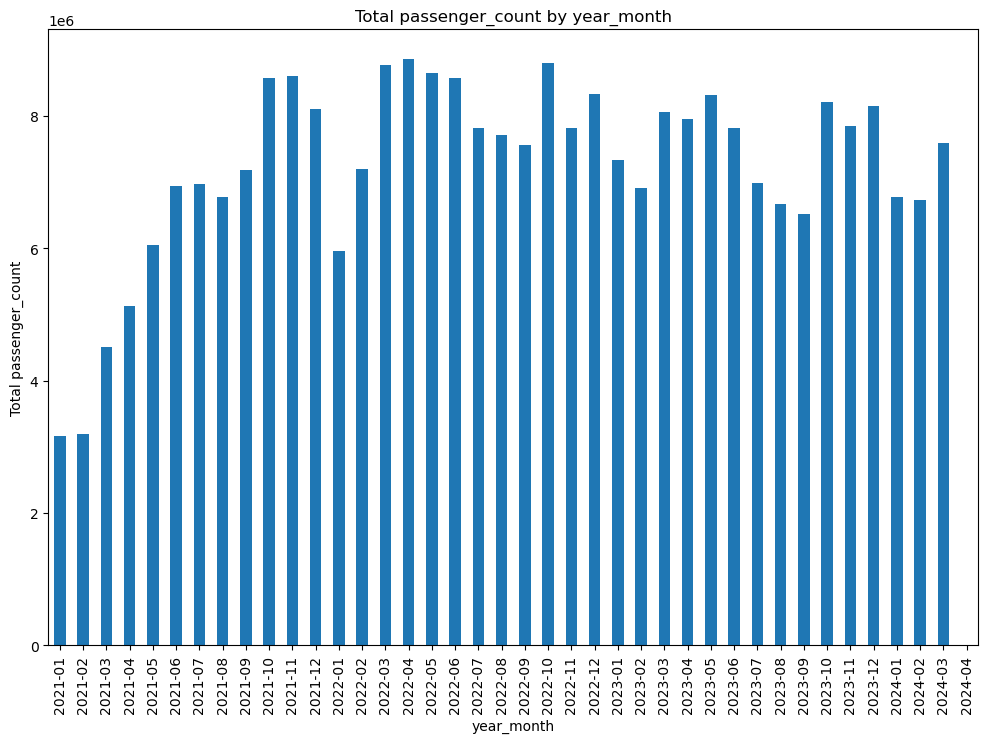

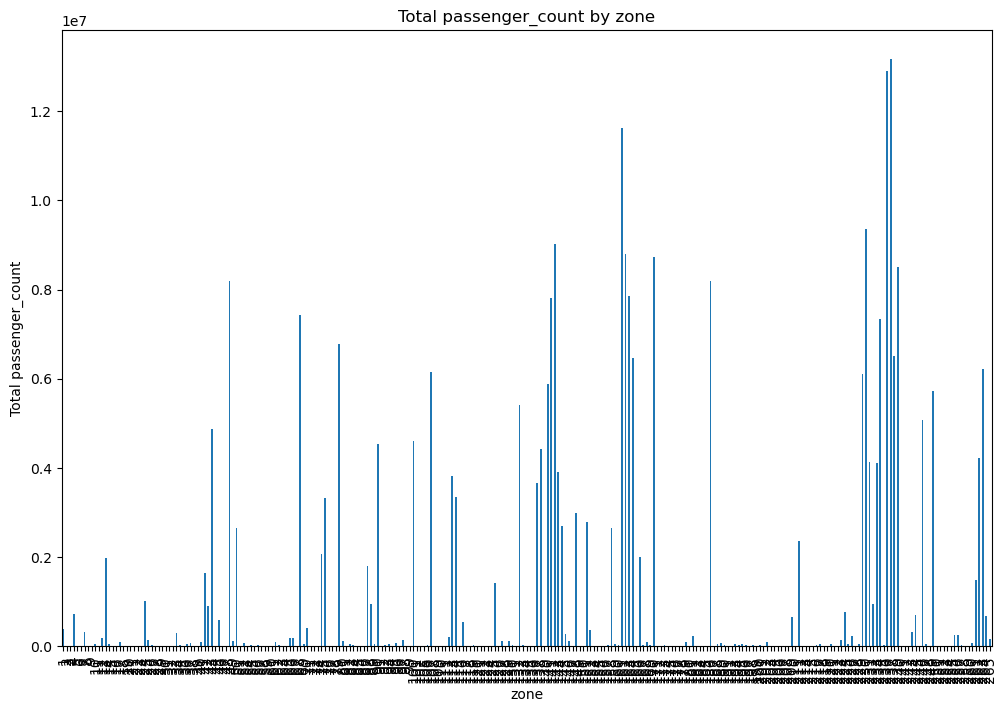

In [41]:
def plot_passenger_count(df, feature):
    # Calculate the total passenger_count for each value in the feature
    passenger_counts = df.groupby(feature)["passenger_count"].sum()

    # Filter features where the total passenger_count is greater than 200 (for better graphing)
    valid_features = passenger_counts[passenger_counts > 200].index.tolist()
    filtered_df = df[df[feature].isin(valid_features)]

    # Plot the total passenger_count
    passenger_counts.plot(kind="bar", figsize=(12, 8))
    plt.title(f"Total passenger_count by {feature}")
    plt.ylabel("Total passenger_count")
    plt.xlabel(feature)
    plt.show()

# List of columns to group by
groupby_columns = ["hour", "day_of_week", "week", "month", "day_of_month", "year_month", "zone"]

# Compute and plot total passenger_count for each category
for column in groupby_columns:
    plot_passenger_count(df, column)

In [ ]:
X = zone_busy_df[['hour', 'day_of_week', 'week', 'month', 'zone']]
y = zone_busy_df['passenger_count']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['hour', 'week']),
        ('cat', OneHotEncoder(), ['day_of_week', 'month', 'zone'])
    ])

# Example model pipeline (using a simple linear regression model)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
model.fit(X_train, y_train)

# Evaluate the model
score = model.score(X_test, y_test)
print(f"Model R^2 Score: {score}")

# Predictions (for example purposes)
predictions = model.predict(X_test)